In [42]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from typing import List
from matplotlib.gridspec import GridSpec
from keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [43]:
df = pd.read_csv('evaluation_dataset.csv', sep=';')

print(df)

     Image  Gender Beard Glasses Haircolor  Nation
0   01.jpg    Male   Yes      No     Brown   White
1   02.jpg    Male   Yes      No     Brown   White
2   03.jpg  Female    No     Yes     Black  Indian
3   04.jpg    Male   Yes      No     Black   Black
4   05.jpg    Male   Yes      No      Gray   White
5   06.jpg    Male    No      No     Black   Black
6   07.jpg  Female    No      No     Black  Indian
7   08.jpg  Female    No      No     Black   Black
8   09.jpg    Male   Yes      No      Gray   Black
9   10.jpg  Female    No     Yes      Gray   White
10  11.jpg    Male   Yes      No     Brown   White
11  12.jpg    Male    No      No     Black   White
12  13.jpg  Female    No      No     Black   White
13  14.jpg    Male   Yes      No     Black   White


# Plot now the images with their actual value and predicted value

In [3]:
images_dir = "Images/"

gender_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Gender_classification"))
beard_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Beard_classification"))
glasses_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Glasses_classification"))
haircolor_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Haircolor_classification"))
nation_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Nation_classification"))

gender_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Gender_classification"))
beard_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Beard_classification"))
glasses_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Glasses_classification"))
haircolor_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Haircolor_classification"))
nation_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Nation_classification"))

2025-07-12 09:28:55.557552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46733 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-07-12 09:28:55.558899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46725 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [44]:
# Class names for categorical prediction
gender_class_names = ['Female', 'Male']
beard_class_names = ['Yes', 'No']
glasses_class_names = ['Yes', 'No']
haircolor_class_names = ['Black', 'Blond', 'Brown', 'Gray']
nation_class_names = ['Asian', 'Black', 'Indian', 'Other', 'White']

In [64]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array
    
    #img = Image.open(img_path).convert("RGB")
    #img = img.resize(target_size)
    #img_array = img_to_array(img)
    #img_array = np.expand_dims(img_array, axis=0)
    #img_array = img_array / 255.0
    #return img_array


def predict_and_display_images(models, df):
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Directory {images_dir} doesn't exist!")
        
    predictions = []
    displayed = 0

    for index, row in df.iterrows():
        image_name = row['Image']
        
        if image_name[:-4] < "11":
            continue
        
        image_path = os.path.join(images_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Error: Image {image_path} not found!")
            continue

        img_array = preprocess_image(image_path)

        gender_pred = models[0].predict(img_array, verbose=0)
        beard_pred = models[1].predict(img_array, verbose=0)
        glasses_pred = models[2].predict(img_array, verbose=0)
        haircolor_pred = models[3].predict(img_array, verbose=0)
        nation_pred = models[4].predict(img_array, verbose=0)

        gender_predicted_labels = (gender_pred > 0.5).astype(int).flatten()
        gender_label = gender_class_names[gender_predicted_labels[0]]
        
        beard_predicted_labels = (beard_pred > 0.5).astype(int).flatten()
        beard_label = beard_class_names[beard_predicted_labels[0]]
        
        glasses_predicted_labels = (glasses_pred > 0.5).astype(int).flatten()
        glasses_label = glasses_class_names[glasses_predicted_labels[0]]
        
        haircolor_label_index = np.argmax(haircolor_pred, axis=1)[0]
        haircolor_label = haircolor_class_names[haircolor_label_index]
        
        nation_label_index = np.argmax(nation_pred, axis=1)[0]
        nation_label = nation_class_names[nation_label_index]
        
        
        predictions.append({
            "Image": image_name,
            "Gender_Pred": gender_label,
            "Beard_Pred": beard_label,
            "Glasses_Pred": glasses_label,
            "Haircolor_Pred": haircolor_label,
            "Nation_Pred": nation_label
        })

        gt_gender = row['Gender']
        gt_beard = row['Beard']
        gt_glasses = row['Glasses']
        gt_haircolor = row['Haircolor']
        gt_nation = row['Nation']

        fig = plt.figure(figsize=(11, 4))
        gs = GridSpec(1, 2, width_ratios=[1, 1.5])

        ax_img = fig.add_subplot(gs[0])
        ax_img.imshow(load_img(image_path))
        ax_img.axis('off')
        ax_img.set_title(f"Image: {image_name[:-4]}", fontsize=13, pad=10)

        lines = [
            f"Gender:     {gender_label:<8}  (GT: {gt_gender})",
            f"Beard:      {beard_label:<8}  (GT: {gt_beard})",
            f"Glasses:    {glasses_label:<8}  (GT: {gt_glasses})",
            f"Haircolor:  {haircolor_label:<8}  (GT: {gt_haircolor})",
            f"Nation:     {nation_label:<8}  (GT: {gt_nation})"
        ]
        text = "\n".join(lines)

        ax_text = fig.add_subplot(gs[1])
        ax_text.axis('off')
        ax_text.text(
            0.0, 0.5, text,
            fontsize=13,
            verticalalignment='center',
            horizontalalignment='left',
            family='monospace',
            transform=ax_text.transAxes
        )

        plt.tight_layout()
        plt.show()

        displayed += 1
        
    pred_df = pd.DataFrame(predictions)
    df_with_preds = pd.merge(df, pred_df, on="Image", how="inner")

    return df_with_preds

# Prediction of the Images without using the Data Augmentation Pipeline

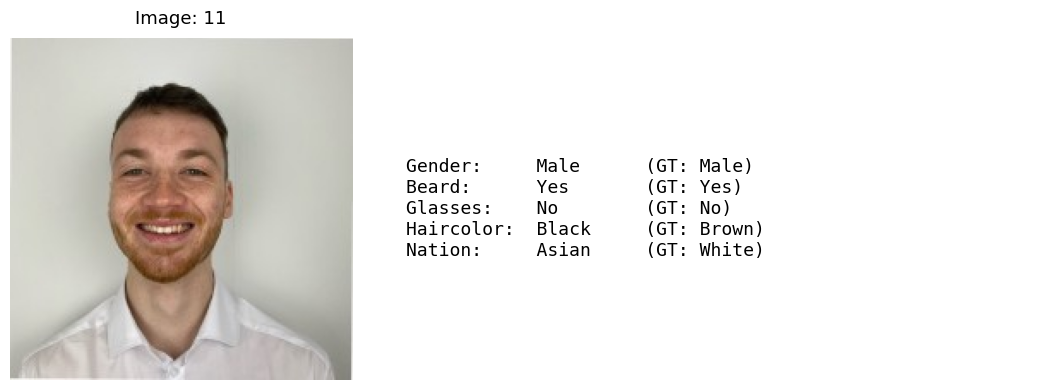

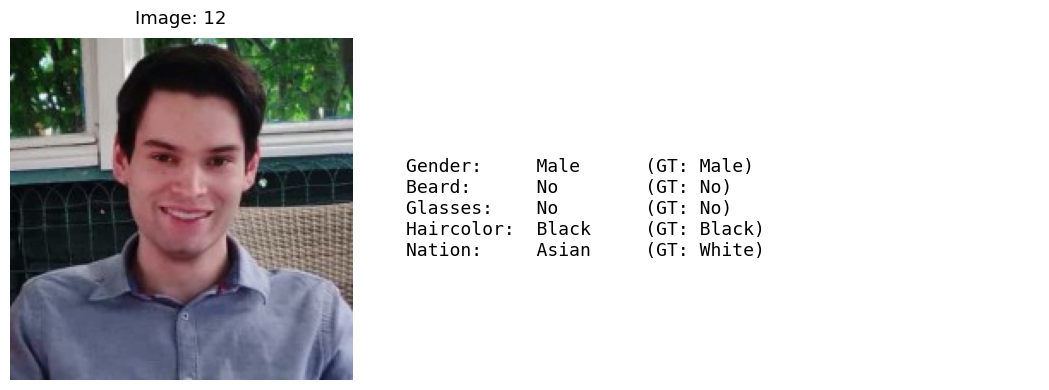

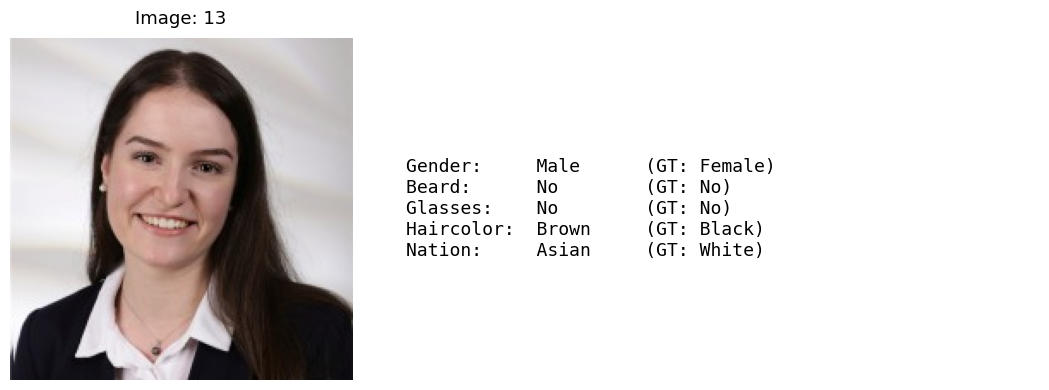

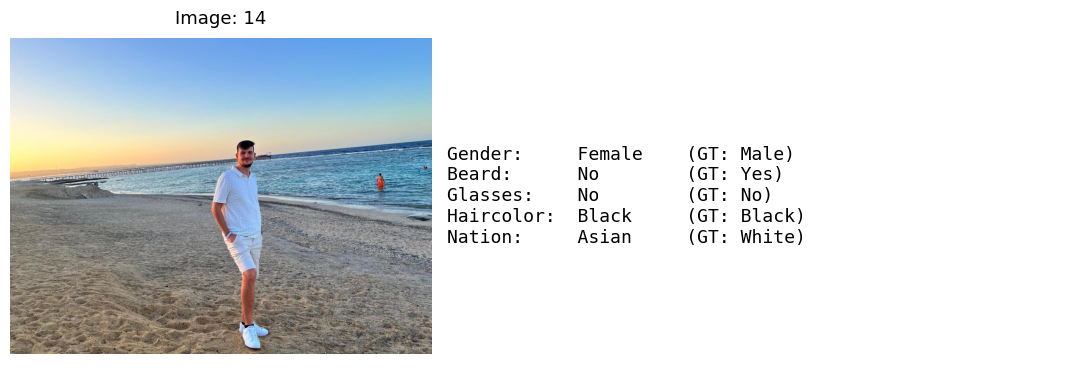

In [65]:
df_preds_without_pipeline = predict_and_display_images(
    models=[gender_model_without_pipeline, beard_model_without_pipeline, glasses_model_without_pipeline, haircolor_model_without_pipeline, nation_model_without_pipeline],
    df=df
)

# Prediction of the Images with using the Data Augmentation Pipeline

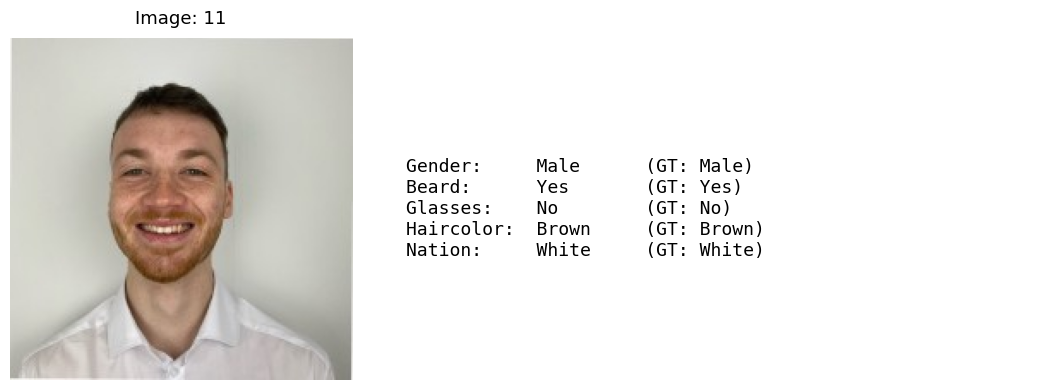

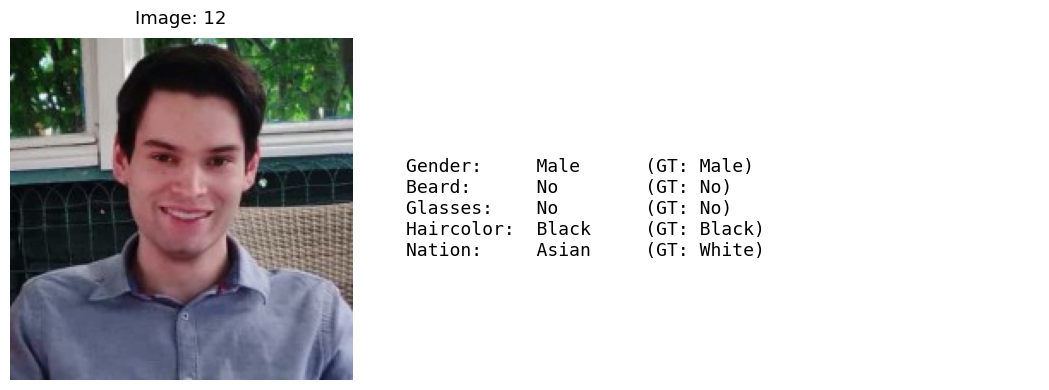

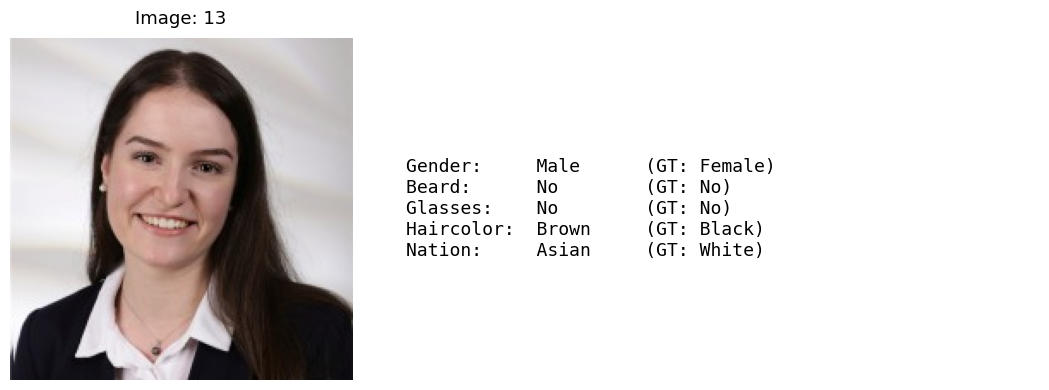

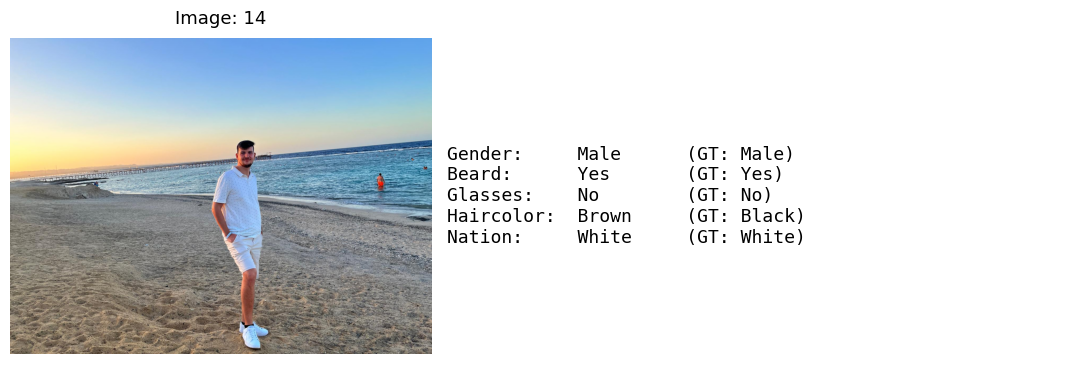

In [66]:
df_preds_with_pipeline = predict_and_display_images(
    models=[gender_model_with_pipeline, beard_model_with_pipeline, glasses_model_with_pipeline, haircolor_model_with_pipeline, nation_model_with_pipeline],
    df=df
)

Gender:


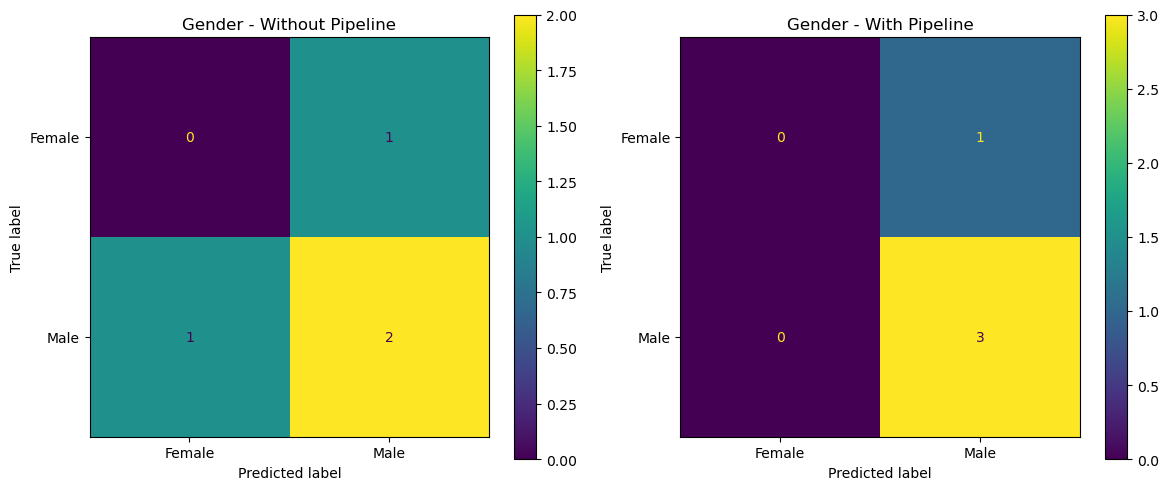

Beard:


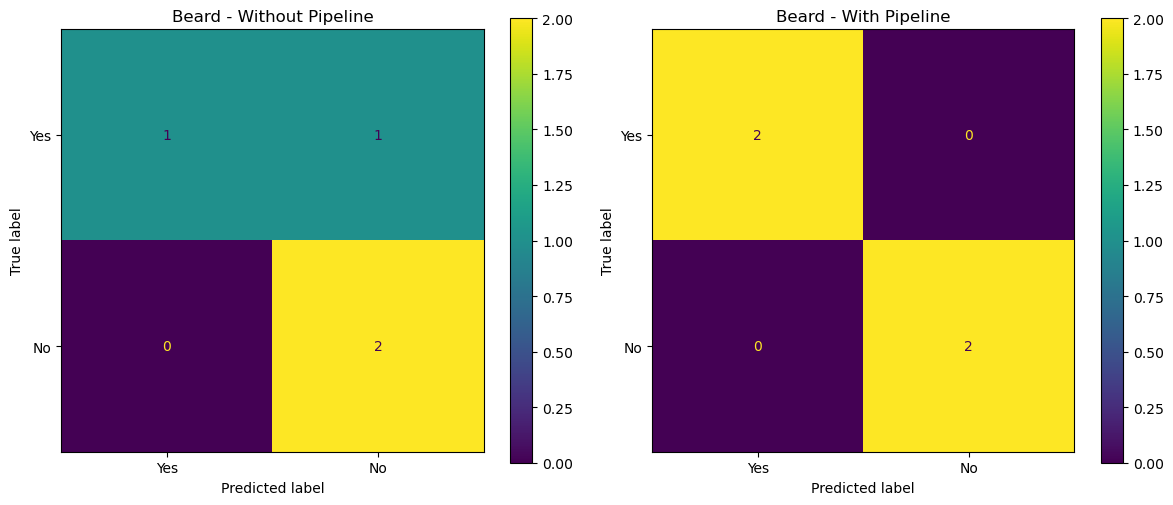

Glasses:


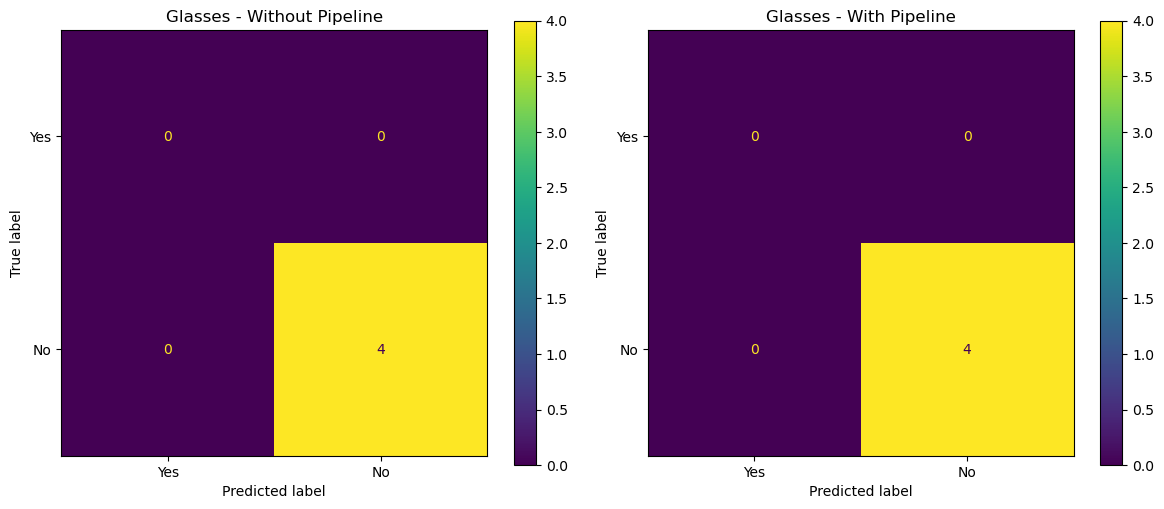

Haircolor:


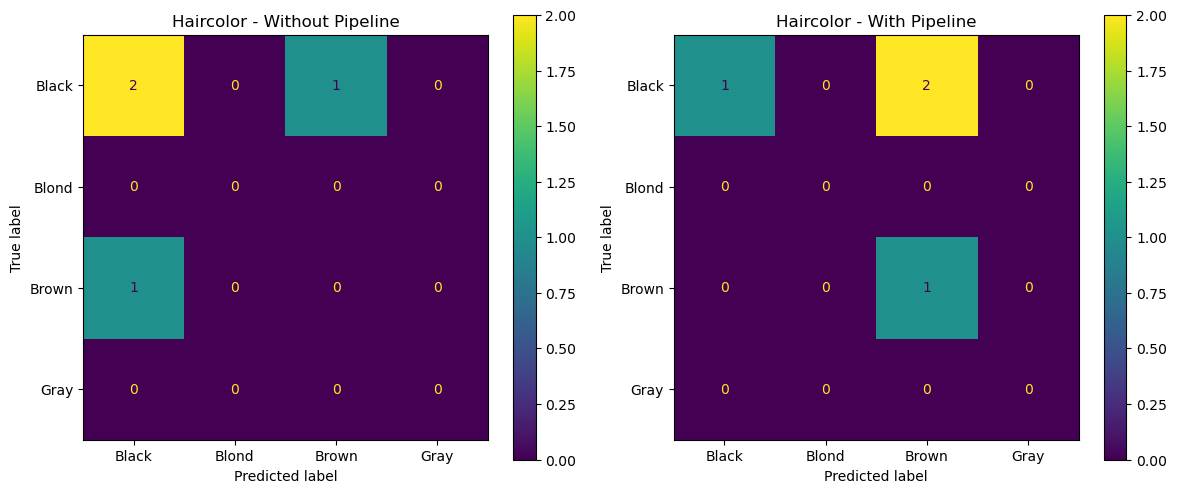

Nation:


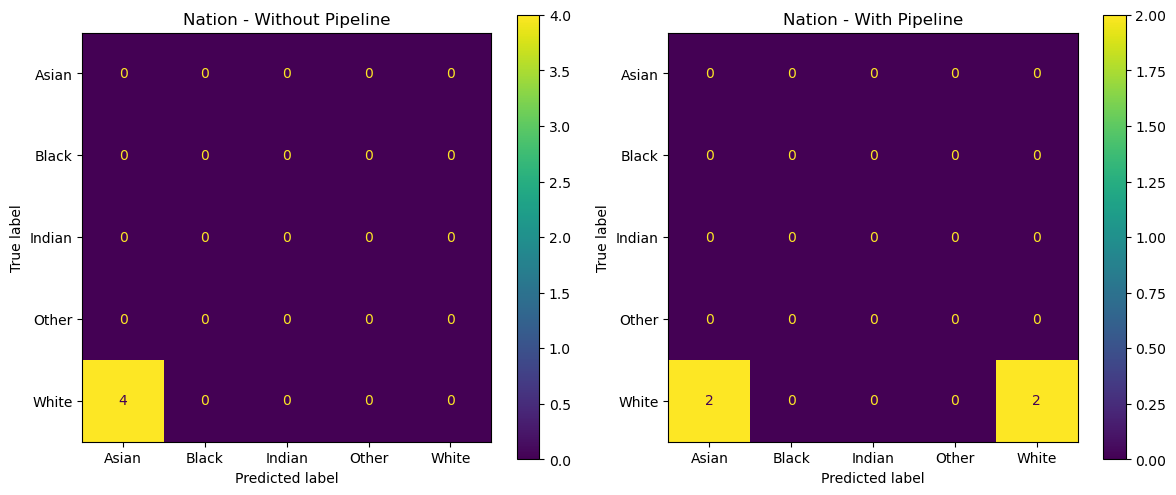

In [67]:
properties = ["Gender", "Beard", "Glasses", "Haircolor", "Nation"]
labels_dict = {
    "Gender": ['Female', 'Male'],
    "Beard": ["Yes", "No"],
    "Glasses": ["Yes", "No"],
    "Haircolor": ["Black", "Blond", "Brown", "Gray"],
    "Nation": ["Asian", "Black", "Indian", "Other", "White"]
}

for prop in properties:
    print(f"{prop}:")

    #print("Without Pipeline:")
    #print(classification_report(df_preds_without_pipeline[prop], df_preds_without_pipeline[f"{prop}_Pred"]))

    #print("With Pipeline:")
    #print(classification_report(df_preds_with_pipeline[prop], df_preds_with_pipeline[f"{prop}_Pred"]))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    cm_without = confusion_matrix(
        df_preds_without_pipeline[prop], 
        df_preds_without_pipeline[f"{prop}_Pred"], 
        labels=labels_dict[prop]
    )
    disp_without = ConfusionMatrixDisplay(confusion_matrix=cm_without, display_labels=labels_dict[prop])
    disp_without.plot(ax=axes[0])
    axes[0].set_title(f"{prop} - Without Pipeline")

    cm_with = confusion_matrix(
        df_preds_with_pipeline[prop], 
        df_preds_with_pipeline[f"{prop}_Pred"], 
        labels=labels_dict[prop]
    )
    disp_with = ConfusionMatrixDisplay(confusion_matrix=cm_with, display_labels=labels_dict[prop])
    disp_with.plot(ax=axes[1])
    axes[1].set_title(f"{prop} - With Pipeline")

    plt.tight_layout()
    plt.show()